In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from pdhg import pdhg_method_AB, prox_l1, check_dual_feasible

## Solving problem 
$$
\begin{array}{ll}
\text{minimize} & q(z) + h(x) \\
\text{subject to} & x = Az
\end{array}
$$

### Special case
$$
\begin{array}{ll}
\text{minimize} & g^\top z  \\
\text{subject to} & \|Az\|_{\max} \leq \beta 
\end{array}
$$
where $g \in \mathcal{R}(A^\top)$

## PDHG 
$$
\begin{aligned}
y^{t+1} &= \operatorname{prox}_{\rho h^*}\!\bigl(y^t + \rho\, A(2 z^t - z^{t-1})\bigr), \\
z^{t+1} &= \operatorname{prox}_{\gamma q}\!\bigl(z^t - \gamma A^\top y^{t+1}\bigr).
\end{aligned}
$$

Residuals
$$
\begin{aligned}
r_1^{t+1} &= \frac{1}{\rho}\left (y^{t+1} - y^t - \rho A(2z^t - z^{t-1} - z^{t+1})\right ) \\
r_2^{t+1} &= \frac{1}{\gamma} \left (z^{t+1} - z^t \right)
\end{aligned}
$$
The stopping cirterion is
$$
\begin{aligned}
 \|r_1^{t+1}\|_2 &\leq \sqrt{m} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|Az^{t+1}\|_2\\
 \|r_2^{t+1}\|_2 &\leq \sqrt{n} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|A^\top y^{t+1}\|_2.
\end{aligned}
$$


In [2]:
def cvxpy_A(g, A, beta, mu=0):
    z = cp.Variable(A.shape[1])
    obj = g.T @ z
    if mu > 0:
        obj += (mu / 2) * cp.sum_squares(z)
    objective = cp.Minimize(obj)
    constraints = [cp.norm(A @ z, "inf") <= beta]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)
    assert prob.status == "optimal", print("CVXPY problem status:", prob.status)
    return z.value, constraints[0].dual_value


In [3]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
np.random.seed(0)
for (m, n) in [(50, 100), (100, 50)]:
    for _ in range(5):
        A_np = np.random.randn(m, n)
        G1_np = A_np.T @ np.random.randn(m, 1)
        beta = 1
        
        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device).t()
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device) 

        nA = torch.linalg.norm(A, ord="fro").item()
        lamb_max = nA
        mu_reg = max(1e-6 * lamb_max**2, 1e-6)
        z0, y0 = cvxpy_A(G1_np, A_np, beta, mu=mu_reg) 

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho: prox_l1(y, rho * beta)

        # Run torch PDHG
        Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            W_k=None,
            W_q=A,
            G_wk=G1,
            G_wq=None,
            mu=mu_reg,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=True,
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy() 

        assert np.allclose(z0.T @ G1_np, Z1.T @ G1_np, atol=1e-3, rtol=1e-3), print(z0.T @ G1_np, Z1.T @ G1_np)
        assert np.linalg.norm(A_np @ Z1, np.inf) <= beta + 1e-2 and np.linalg.norm(A_np @ z0, np.inf) <= beta + 1e-2
        print("PASSED")

lamb_max=69.6816177368164
||Y||_F=7.9901e+00
PASSED
lamb_max=69.87359619140625
||Y||_F=7.0482e+00
PASSED
lamb_max=70.407470703125
||Y||_F=6.6196e+00
PASSED
lamb_max=70.07579803466797
||Y||_F=6.4975e+00
PASSED
lamb_max=70.307373046875
||Y||_F=6.9068e+00
PASSED
lamb_max=70.96698760986328
||Y||_F=7.4550e+00
PASSED
lamb_max=71.32703399658203
||Y||_F=9.3362e+00
PASSED
lamb_max=70.76106262207031
||Y||_F=7.7879e+00
PASSED
lamb_max=70.61338806152344
||Y||_F=9.0793e+00
PASSED
lamb_max=70.82266235351562
||Y||_F=9.3997e+00
PASSED


In [5]:
def plot_residuals(residuals):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    spec = [
        ('r1','r2','Absolute residuals', r'$r_1$', r'$r_2$'),
        ('r1_rel','r2_rel','Relative residuals', r'$r_1^{\text{rel}}$', r'$r_2^{\text{rel}}$')
    ]
    for i, (k1, k2, title, l1, l2) in enumerate(spec):
        d1, d2 = residuals.get(k1, []), residuals.get(k2, [])
        if len(d1) and len(d2):
            ax[i].plot(d1, label=l1); ax[i].plot(d2, label=l2)
            ax[i].set(yscale='log', title=title, xlabel='iteration')
            ax[i].grid(True, which='both', ls='--', alpha=0.4); ax[i].legend()
        else:
            ax[i].axis('off')
    plt.tight_layout()

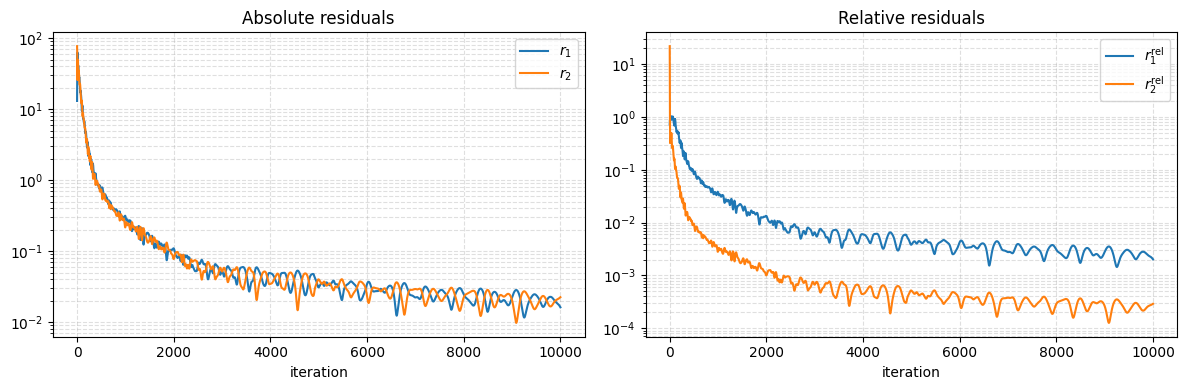

In [6]:
plot_residuals(residuals)

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


In [7]:
def cvxpy_AB(G1, G2, A, B, beta, mu=0):
    Z1, Z2 = cp.Variable(A.shape), cp.Variable(B.shape)
    obj = cp.trace(G1.T @ Z1) + cp.trace(G2.T @ Z2)
    if mu > 0:
        obj += (mu / 2) * (cp.sum_squares(Z1) + cp.sum_squares(Z2))
    objective = cp.Minimize(obj)
    constraints = [cp.max(cp.abs(Z1.T @ B + A.T @ Z2)) <= beta]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)
    assert prob.status in ["optimal", "optimal_inaccurate"], print(prob.status)
    return Z1.value, Z2.value

In [ ]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-6 * lamb_max**2, 1e-6)

        Z0_1, Z0_2 = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho: prox_l1(y, rho * beta)

        # Run torch PDHG
        Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            W_k=A,
            W_q=B,
            G_wk=G1,
            G_wq=G2,
            mu=mu_reg,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=True,
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

lamb_max=60.042948911588766
||Y||_F=5.5691e+01
PASSED
lamb_max=59.77968455958715
||Y||_F=5.4036e+01
PASSED
lamb_max=60.78409843290087
||Y||_F=5.6751e+01
PASSED
lamb_max=59.37420393691023
||Y||_F=5.6563e+01
PASSED
lamb_max=60.361789696788186
||Y||_F=5.6815e+01
PASSED
lamb_max=60.08138897182345
||Y||_F=3.0195e+01
PASSED
lamb_max=60.04998184496628
||Y||_F=3.1280e+01
PASSED
lamb_max=59.64461369023844
||Y||_F=2.8876e+01
PASSED
lamb_max=59.72348211615672
||Y||_F=2.9236e+01
PASSED
lamb_max=60.91859389058868
||Y||_F=3.0148e+01
PASSED


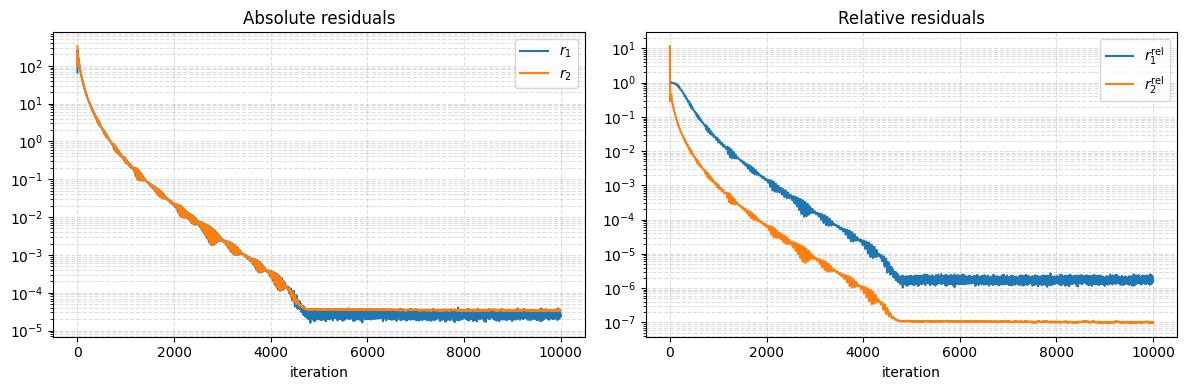

In [9]:
plot_residuals(residuals)

In [ ]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = check_dual_feasible(A, B, G1, G2)
    print(f"{dual_res=}")
    nA = torch.linalg.norm(A, ord="fro").item()
    nB = torch.linalg.norm(B, ord="fro").item()
    lamb_max = (nA * nA + nB * nB) ** 0.5
    mu_reg = max(1e-6 * lamb_max**2, 1e-6)

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho: prox_l1(y, rho * beta)

    # Run torch PDHG
    Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
        prox_h_conj,
        W_k=A,
        W_q=B,
        G_wk=G1,
        G_wq=G2,
        mu=mu_reg,
        max_iter=50000,
        eps_abs=1e-8,
        eps_rel=1e-8,
        stopping=True, 
    )

    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


dual_res=9.04950850018755e-08
lamb_max=706.9753509699622


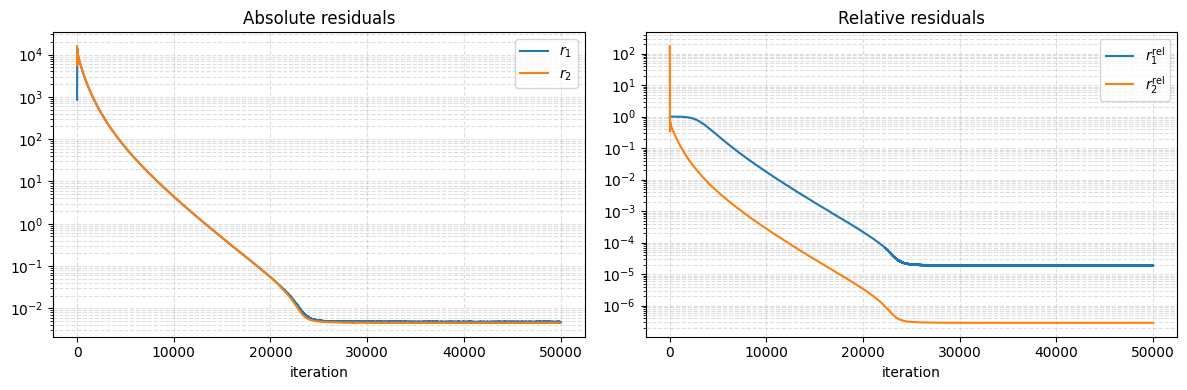

In [18]:
plot_residuals(residuals)